# Data Preprocessing

In [2]:
# Import Libraries

import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
import re
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import os
import time
warnings.filterwarnings('ignore')


# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vrajd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vrajd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vrajd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\vrajd\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
# Load dataset
df = pd.read_csv('mtsamples.csv')

In [4]:
df.sample(5)

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
1937,1937,A 2-month-old female with 1-week history of c...,Pediatrics - Neonatal,Congestion & Fever - 2-month-old,"CHIEF COMPLAINT:, A 2-month-old female with 1...",NaN
1109,1109,Left calcaneal lengthening osteotomy with all...,Surgery,Calcaneal Lengthening Osteotomy,"PREOPERATIVE DIAGNOSES:, Left calcaneal valgu...","surgery, calcaneal lengthening, osteotomy, all..."
1069,1069,Left knee arthroscopy with removal of the car...,Surgery,Cartilage Loose Body Removal,"PREOPERATIVE DIAGNOSIS: , Left knee medial fem...","surgery, knee arthroscopy, chondroplasty, medi..."
894,894,Degenerative disk disease at L4-L5 and L5-S1....,Surgery,Diskectomy & Fusion,"PREOPERATIVE DIAGNOSIS: , Degenerative disk di...","surgery, anterior exposure, degenerative disk ..."
11,11,"Normal left ventricle, moderate biatrial enla...",Cardiovascular / Pulmonary,2-D Doppler,"2-D STUDY,1. Mild aortic stenosis, widely calc...","cardiovascular / pulmonary, 2-d study, doppler..."


In [5]:
df.columns

Index(['Unnamed: 0', 'description', 'medical_specialty', 'sample_name',
       'transcription', 'keywords'],
      dtype='object')

In [6]:
df.medical_specialty.unique()

array([' Allergy / Immunology', ' Bariatrics',
       ' Cardiovascular / Pulmonary', ' Neurology', ' Dentistry',
       ' Urology', ' General Medicine', ' Surgery', ' Speech - Language',
       ' SOAP / Chart / Progress Notes', ' Sleep Medicine',
       ' Rheumatology', ' Radiology', ' Psychiatry / Psychology',
       ' Podiatry', ' Physical Medicine - Rehab',
       ' Pediatrics - Neonatal', ' Pain Management', ' Orthopedic',
       ' Ophthalmology', ' Office Notes', ' Obstetrics / Gynecology',
       ' Neurosurgery', ' Nephrology', ' Letters',
       ' Lab Medicine - Pathology', ' IME-QME-Work Comp etc.',
       ' Hospice - Palliative Care', ' Hematology - Oncology',
       ' Gastroenterology', ' ENT - Otolaryngology', ' Endocrinology',
       ' Emergency Room Reports', ' Discharge Summary',
       ' Diets and Nutritions', ' Dermatology',
       ' Cosmetic / Plastic Surgery', ' Consult - History and Phy.',
       ' Chiropractic', ' Autopsy'], dtype=object)

In [7]:
len(df.sample_name.unique())

2377

In [8]:
df.description[0]

' A 23-year-old white female presents with complaint of allergies.'

In [9]:
df.transcription[0]

'SUBJECTIVE:,  This 23-year-old white female presents with complaint of allergies.  She used to have allergies when she lived in Seattle but she thinks they are worse here.  In the past, she has tried Claritin, and Zyrtec.  Both worked for short time but then seemed to lose effectiveness.  She has used Allegra also.  She used that last summer and she began using it again two weeks ago.  It does not appear to be working very well.  She has used over-the-counter sprays but no prescription nasal sprays.  She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: , Her only medication currently is Ortho Tri-Cyclen and the Allegra.,ALLERGIES: , She has no known medicine allergies.,OBJECTIVE:,Vitals:  Weight was 130 pounds and blood pressure 124/78.,HEENT:  Her throat was mildly erythematous without exudate.  Nasal mucosa was erythematous and swollen.  Only clear drainage was seen.  TMs were clear.,Neck:  Supple without adenopathy.,

In [10]:
df.keywords[0]

'allergy / immunology, allergic rhinitis, allergies, asthma, nasal sprays, rhinitis, nasal, erythematous, allegra, sprays, allergic,'

In [11]:
df.description[2]

' Consult for laparoscopic gastric bypass.'

In [12]:
df.isnull().sum()

Unnamed: 0              0
description             0
medical_specialty       0
sample_name             0
transcription          33
keywords             1068
dtype: int64

In [13]:
# Combine transcription and keywords, handle missing values
df['text'] = df['transcription'].fillna('') + ' ' + df['keywords'].fillna('')

In [14]:
# Drop unnecessary columns and handle missing values
df = df[['text', 'medical_specialty']].dropna()

In [15]:
df.columns

Index(['text', 'medical_specialty'], dtype='object')

In [16]:
df.isnull().sum()

text                 0
medical_specialty    0
dtype: int64

In [17]:
# Combine low-frequency classes
counts = df['medical_specialty'].value_counts()
others = [k for k, v in counts.items() if v < 100]
df.loc[df['medical_specialty'].isin(others), 'medical_specialty'] = 'others'

In [18]:
df.columns

Index(['text', 'medical_specialty'], dtype='object')

In [19]:
df.medical_specialty.unique()

array(['others', ' Cardiovascular / Pulmonary', ' Neurology', ' Urology',
       ' General Medicine', ' Surgery', ' SOAP / Chart / Progress Notes',
       ' Radiology', ' Orthopedic', ' Obstetrics / Gynecology',
       ' Gastroenterology', ' Discharge Summary',
       ' Consult - History and Phy.'], dtype=object)

In [20]:
# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['medical_specialty'])

In [21]:
df.columns

Index(['text', 'medical_specialty', 'label'], dtype='object')

In [22]:
# Analyze text length
df['text_length'] = df['text'].apply(lambda x: len(word_tokenize(x)))
print("Text Length Stats:")
print(df['text_length'].describe())

Text Length Stats:
count    4999.000000
mean      580.543309
std       357.276469
min         4.000000
25%       324.000000
50%       512.000000
75%       758.000000
max      3489.000000
Name: text_length, dtype: float64


In [23]:
df.label.unique()

array([12,  0,  5, 11,  4, 10,  9,  8,  7,  6,  3,  2,  1])

In [46]:
num_classes = len(label_encoder.classes_)

In [24]:
# Display class distribution
print("Class Distribution:")
print(df['medical_specialty'].value_counts())

Class Distribution:
medical_specialty
 Surgery                          1103
others                            1076
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        372
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  230
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Obstetrics / Gynecology           160
 Urology                           158
 Discharge Summary                 108
Name: count, dtype: int64


In [25]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
text                 0
medical_specialty    0
label                0
text_length          0
dtype: int64


In [26]:
df.shape

(4999, 4)

In [27]:
df.columns

Index(['text', 'medical_specialty', 'label', 'text_length'], dtype='object')

# Text Representation(Preprocessing)

In [28]:
# Define medical keywords to preserve 
medical_keywords_to_preserve = {
    'abdomen', 'abdominal', 'abnormal', 'absent', 'acute', 'admission', 'analgesic', 'anemia', 'anesthesia', 
    'angioplasty', 'antibiotic', 'anticoagulant', 'antihypertensive', 'artery', 'arthritis', 'assessment', 'asthma', 
    'back', 'benefit', 'biopsy', 'bladder', 'bleeding', 'blood', 'bone', 'brain', 'breath', 'cancer', 'capsule', 
    'cardiac', 'cardiovascular', 'care', 'catheterization', 'chest', 'cholesterol', 'chronic', 'clinic', 'clinical', 
    'colon', 'colonoscopy', 'complication', 'condition', 'consent', 'consult', 'cough', 'creatinine', 'ct', 'culture', 
    'denies', 'diabetes', 'diagnosis', 'dialysis', 'diarrhea', 'dizziness', 'doctor', 'dose', 'dosage', 'drainage', 
    'drug', 'dyspnea', 'ear', 'echocardiogram', 'edema', 'electrocardiogram', 'electrolyte', 'elevated', 'emergency', 
    'endoscopy', 'epilepsy', 'er', 'evaluation', 'exam', 'extremity', 'eye', 'failure', 'fatigue', 'fever', 'fibrosis', 
    'followup', 'fracture', 'gastroenterology', 'gastrointestinal', 'glucose', 'gynecology', 'headache', 'heart', 
    'height', 'hemoglobin', 'hepatitis', 'history', 'hospital', 'hypertension', 'hysterectomy', 'icu', 'imaging', 
    'incision', 'infection', 'infusion', 'injection', 'inpatient', 'insulin', 'intestine', 'intubation', 'intraoperative', 
    'intravenous', 'intramuscular', 'itchiness', 'iv', 'joint', 'kidney', 'laparoscopy', 'liver', 'lung', 'management', 
    'mastectomy', 'medical', 'medication', 'mild', 'moderate', 'monitoring', 'mri', 'muscle', 'musculoskeletal', 
    'nausea', 'neck', 'negative', 'nerve', 'neurologic', 'neurology', 'normal', 'note', 'numbness', 'nurse', 'obesity', 
    'obstetrics', 'operation', 'oral', 'orthopedic', 'outpatient', 'oxygen', 'pain', 'palpitations', 'pancreas', 
    'patient', 'pelvis', 'physical', 'physician', 'platelet', 'pneumonia', 'positive', 'postoperative', 'preoperative', 
    'prescription', 'pressure', 'primary', 'procedure', 'progress', 'prognosis', 'prostate', 'provider', 'pulmonary', 
    'pulse', 'radiology', 'rash', 'rate', 'recovery', 'recurrent', 'referral', 'rehabilitation', 'renal', 'resection', 
    'respiration', 'respiratory', 'result', 'rhinitis', 'risk', 'saturation', 'scan', 'secondary', 'seizure', 'sepsis', 
    'severe', 'shortness', 'sign', 'skin', 'spleen', 'spine', 'stable', 'staff', 'stent', 'stomach', 'stroke', 
    'subcutaneous', 'summary', 'support', 'surgery', 'suture', 'swelling', 'symptom', 'syncope', 'tablet', 
    'temperature', 'test', 'therapy', 'throat', 'thrombosis', 'thyroid', 'tingling', 'topical', 'transplant', 
    'treatment', 'tumor', 'ulcer', 'ultrasound', 'unstable', 'urinary', 'urology', 'uterus', 'vascular', 'vein', 
    'ventilation', 'vital', 'vomiting', 'ward', 'weakness', 'weight', 'xray'
}

# Define abbreviations 
abbreviations = {
    'bp': 'blood pressure', 'hr': 'heart rate', 'pt': 'patient', 'dx': 'diagnosis', 'rx': 'prescription', 
    'sob': 'shortness of breath', 'cxr': 'chest xray', 'prn': 'as needed', 'bid': 'twice daily', 
    'tid': 'three times daily', 'qid': 'four times daily', 'stat': 'immediately', 'po': 'by mouth', 
    'iv': 'intravenous', 'im': 'intramuscular', 'sc': 'subcutaneous', 'htn': 'hypertension', 
    'dm': 'diabetes mellitus', 'cad': 'coronary artery disease', 'chf': 'congestive heart failure', 
    'copd': 'chronic obstructive pulmonary disease', 'mi': 'myocardial infarction', 'ua': 'urinalysis', 
    'cbc': 'complete blood count', 'bmp': 'basic metabolic panel', 'ecg': 'electrocardiogram', 
    'echo': 'echocardiogram', 'npo': 'nil per os', 'abx': 'antibiotics', 'ns': 'normal saline', 
    'o2': 'oxygen', 'vss': 'vital signs stable', 'pmh': 'past medical history', 'fh': 'family history', 
    'sh': 'social history', 'ros': 'review of systems', 'pe': 'physical examination', 
    'hpi': 'history of present illness', 'preop': 'preoperative', 'postop': 'postoperative'
}

In [29]:
# Define stopwords and abbreviations
stop_words = set(stopwords.words('english')) - medical_keywords_to_preserve

In [30]:
lemmatizer = WordNetLemmatizer()

In [31]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'
    elif treebank_tag.startswith('V'):
        return 'v'
    elif treebank_tag.startswith('N'):
        return 'n'
    elif treebank_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

In [32]:
def preprocess_text(text):
    
    if not isinstance(text, str):
        return ""
        
    # Remove headers (e.g., SUBJECTIVE:)
    text = re.sub(r'^(SUBJECTIVE|OBJECTIVE|ASSESSMENT|PLAN|MEDICATIONS|ALLERGIES|VITALS|HEENT|NECK|LUNGS):[,]?', ' ', text, flags=re.IGNORECASE)
    
    # Convert to lowercase
    text = text.lower()
    
    # Expand abbreviations
    for abbr, full in abbreviations.items():
        text = text.replace(f' {abbr} ', f' {full} ')
        
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # POS tagging and lemmatization
    tagged = pos_tag(tokens)
    tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in tagged if token not in stop_words and len(token) > 2]
    return ' '.join(tokens)

In [33]:
# Apply preprocessing
df['cleaned_text'] = df['text'].apply(preprocess_text)
df = df[df['cleaned_text'].str.strip() != '']
print("Preprocessing completed. Sample cleaned text:")
print(df['cleaned_text'].iloc[0])

Preprocessing completed. Sample cleaned text:
year old white female present complaint allergy use allergy live seattle think bad past try claritin zyrtec work short time seem lose effectiveness use allegra also use last summer begin use two week ago appear work well use counter spray prescription nasal spray asthma doest require daily medication think flare medication medication currently ortho tri cyclen allegra allergies know medicine allergy objective vitals weight pound blood pressure heent throat mildly erythematous without exudate nasal mucosa erythematous swell clear drainage see tm clear neck supple without adenopathy lung clear assessment allergic rhinitis plan try zyrtec instead allegra another option use loratadine think prescription coverage might cheap sample nasonex two spray nostril give three week prescription write well allergy immunology allergic rhinitis allergy asthma nasal spray rhinitis nasal erythematous allegra spray allergic


In [34]:
df.columns

Index(['text', 'medical_specialty', 'label', 'text_length', 'cleaned_text'], dtype='object')

In [35]:
from nlpaug.augmenter.word.synonym import SynonymAug
import nltk
nltk.download('wordnet')

# Text augmentation for minority classes
aug = SynonymAug(aug_src='wordnet', aug_p=0.3)

def augment_text(text, label, count_threshold=200):
    if df['label'].value_counts()[label] < count_threshold:
        augmented_texts = [aug.augment(text)[0] for _ in range(2)]  # Generate 2 augmented samples
        return [text] + augmented_texts
    return [text]


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vrajd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [36]:
# Apply augmentation
augmented_data = []
for idx, row in df.iterrows():
    texts = augment_text(row['cleaned_text'], row['label'])
    for text in texts:
        augmented_data.append({'cleaned_text': text, 'label': row['label'], 'medical_specialty': row['medical_specialty']})

df_aug = pd.DataFrame(augmented_data)
print("Augmented Class Distribution:")
print(df_aug['medical_specialty'].value_counts())

Augmented Class Distribution:
medical_specialty
 Surgery                          1103
others                            1076
 Consult - History and Phy.        516
 SOAP / Chart / Progress Notes     498
 Obstetrics / Gynecology           480
 Urology                           474
 Cardiovascular / Pulmonary        372
 Orthopedic                        355
 Discharge Summary                 324
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  230
 Neurology                         223
Name: count, dtype: int64


# Data Preparation

In [37]:
# Features and labels
X = df_aug['cleaned_text']
y = df_aug['label']

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (4637,) Test shape: (1546,)


In [38]:
X_train.shape

(4637,)

# Statistical Models

In [38]:
# TF-IDF with increased max_features
tfidf = TfidfVectorizer(max_features=15000, ngram_range=(1, 4), min_df=2, max_df=0.9)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [39]:
X_train_tfidf.shape

(4637, 15000)

In [40]:
# Apply SMOTE for class imbalance
smote = SMOTE(random_state=42)
X_train_tfidf_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)
print("SMOTE TF-IDF shape:", X_train_tfidf_smote.shape)

SMOTE TF-IDF shape: (10751, 15000)


In [41]:
# Compute class weights
class_weights = {i: len(y_train) / (len(label_encoder.classes_) * np.sum(y_train == i)) for i in range(len(label_encoder.classes_))}

In [42]:
# Feature selection with more features
selector = SelectKBest(chi2, k=10000)
X_train_tfidf_selected = selector.fit_transform(X_train_tfidf_smote, y_train_smote)
X_test_tfidf_selected = selector.transform(X_test_tfidf)


Logistic Regression Results (Best Params: {'C': 10, 'penalty': 'l1', 'solver': 'saga'} )
Accuracy: 0.7950, Macro F1: 0.7837, Micro F1: 0.7950
                                precision    recall  f1-score   support

    Cardiovascular / Pulmonary       0.75      0.80      0.77        93
    Consult - History and Phy.       0.47      0.44      0.46       129
             Discharge Summary       0.86      0.90      0.88        81
              Gastroenterology       0.79      0.84      0.81        57
              General Medicine       0.54      0.63      0.58        65
                     Neurology       0.60      0.66      0.63        56
       Obstetrics / Gynecology       0.92      0.97      0.95       120
                    Orthopedic       0.77      0.81      0.79        89
                     Radiology       0.84      0.87      0.86        68
 SOAP / Chart / Progress Notes       0.94      0.93      0.93       125
                       Surgery       0.87      0.86      0.86   

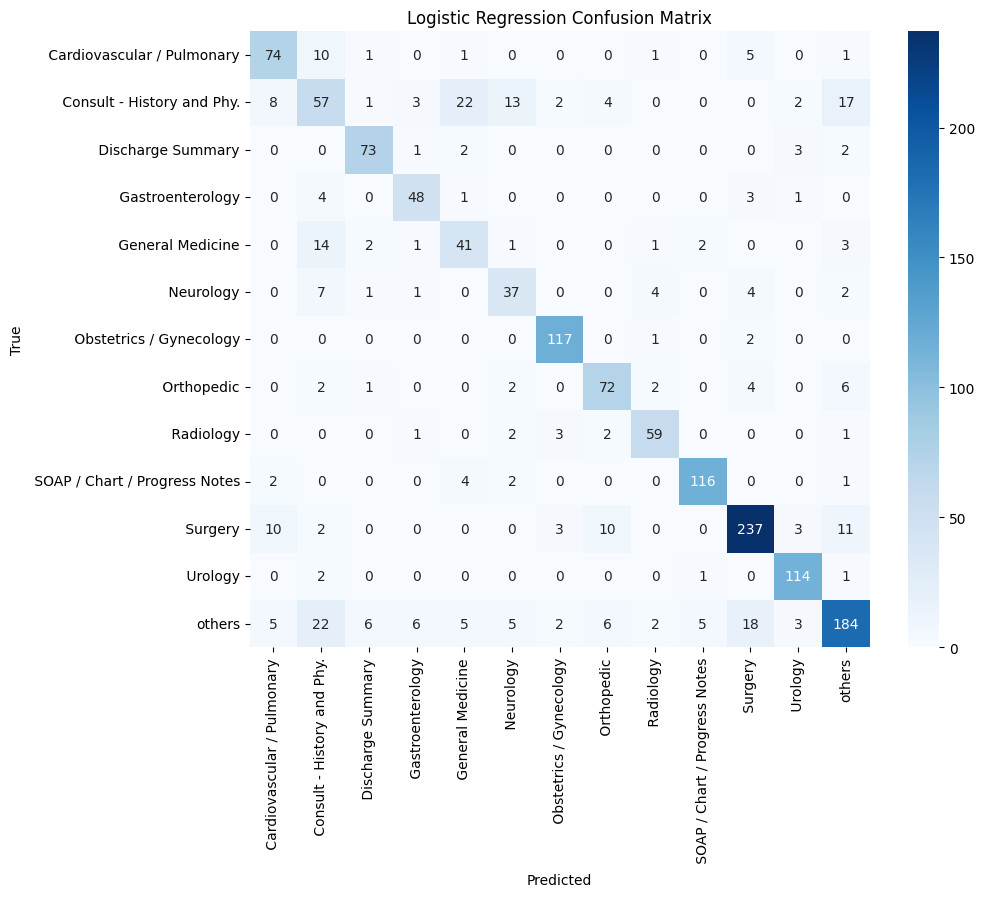

In [44]:
# Logistic Regression with expanded tuning
lr = LogisticRegression(max_iter=1000, multi_class='multinomial')
param_grid_lr = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['saga']
}
grid_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_train_tfidf_selected, y_train_smote)
y_pred_lr = grid_lr.predict(X_test_tfidf_selected)

lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_f1_macro = f1_score(y_test, y_pred_lr, average='macro')
lr_f1_micro = f1_score(y_test, y_pred_lr, average='micro')
print("\nLogistic Regression Results (Best Params:", grid_lr.best_params_, ")")
print(f"Accuracy: {lr_accuracy:.4f}, Macro F1: {lr_f1_macro:.4f}, Micro F1: {lr_f1_micro:.4f}")
print(classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_))
cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [131]:
import sys
print(sys.executable)


C:\Users\vrajd\AppData\Local\Programs\Python\Python311\python.exe


In [139]:
import torch
print("Torch version:", torch.__version__)
print("Torch CUDA version:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())

Torch version: 2.7.1+cpu
Torch CUDA version: None
CUDA available: False


# Transformer Model (BioBERT)

In [43]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup, pipeline
from transformers import pipeline
from tqdm import tqdm

In [44]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [52]:
# Load BioBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

model = AutoModelForSequenceClassification.from_pretrained(
    "dmis-lab/biobert-base-cased-v1.1",
    num_labels=num_classes,
    trust_remote_code=True,
    use_safetensors=True
)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [53]:
# Dataset class
class BERTDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts.tolist()
        self.labels = labels.to_numpy()
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [55]:
from sklearn.utils.class_weight import compute_class_weight
from torch.optim import AdamW


# Create datasets
train_dataset = BERTDataset(X_train, y_train, tokenizer, max_length=512)
test_dataset = BERTDataset(X_test, y_test, tokenizer, max_length=512)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.to_numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=100, num_training_steps=len(train_loader) * 5
)

# Training loop with class-weighted loss
model.train()
for epoch in range(10):
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fn(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    print(f"Epoch {epoch+1} Average Loss: {total_loss / len(train_loader):.4f}")

# Save the model
model.save_pretrained("biobert_medical_specialty_classifier")
tokenizer.save_pretrained("biobert_medical_specialty_classifier")

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [03:33<00:00,  1.36it/s, loss=0.582]


Epoch 1 Average Loss: 1.5833


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [03:33<00:00,  1.36it/s, loss=0.753]


Epoch 2 Average Loss: 0.6234


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [03:32<00:00,  1.36it/s, loss=0.541]


Epoch 3 Average Loss: 0.4885


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [03:32<00:00,  1.36it/s, loss=0.234]


Epoch 4 Average Loss: 0.4149


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [03:32<00:00,  1.36it/s, loss=0.251]


Epoch 5 Average Loss: 0.3604


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [03:32<00:00,  1.37it/s, loss=0.186]


Epoch 6 Average Loss: 0.3287


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [03:32<00:00,  1.37it/s, loss=0.685]


Epoch 7 Average Loss: 0.3292


Epoch 8: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [03:32<00:00,  1.37it/s, loss=0.0554]


Epoch 8 Average Loss: 0.3313


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [03:32<00:00,  1.37it/s, loss=0.264]


Epoch 9 Average Loss: 0.3278


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [03:32<00:00,  1.37it/s, loss=0.528]


Epoch 10 Average Loss: 0.3307


('biobert_medical_specialty_classifier\\tokenizer_config.json',
 'biobert_medical_specialty_classifier\\special_tokens_map.json',
 'biobert_medical_specialty_classifier\\vocab.txt',
 'biobert_medical_specialty_classifier\\added_tokens.json',
 'biobert_medical_specialty_classifier\\tokenizer.json')

Device set to use cuda:0
Predicting: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1546/1546 [00:18<00:00, 83.66it/s]



BioBERT Pipeline Results:
Accuracy: 0.7607, Macro F1: 0.7538, Micro F1: 0.7607
                                precision    recall  f1-score   support

    Cardiovascular / Pulmonary       0.68      0.85      0.75        93
    Consult - History and Phy.       0.47      0.40      0.43       129
             Discharge Summary       0.90      0.90      0.90        81
              Gastroenterology       0.72      0.81      0.76        57
              General Medicine       0.49      0.71      0.58        65
                     Neurology       0.51      0.75      0.61        56
       Obstetrics / Gynecology       0.86      0.96      0.91       120
                    Orthopedic       0.58      0.81      0.68        89
                     Radiology       0.83      0.85      0.84        68
 SOAP / Chart / Progress Notes       0.92      0.88      0.90       125
                       Surgery       0.93      0.68      0.79       276
                       Urology       0.86      0.97    

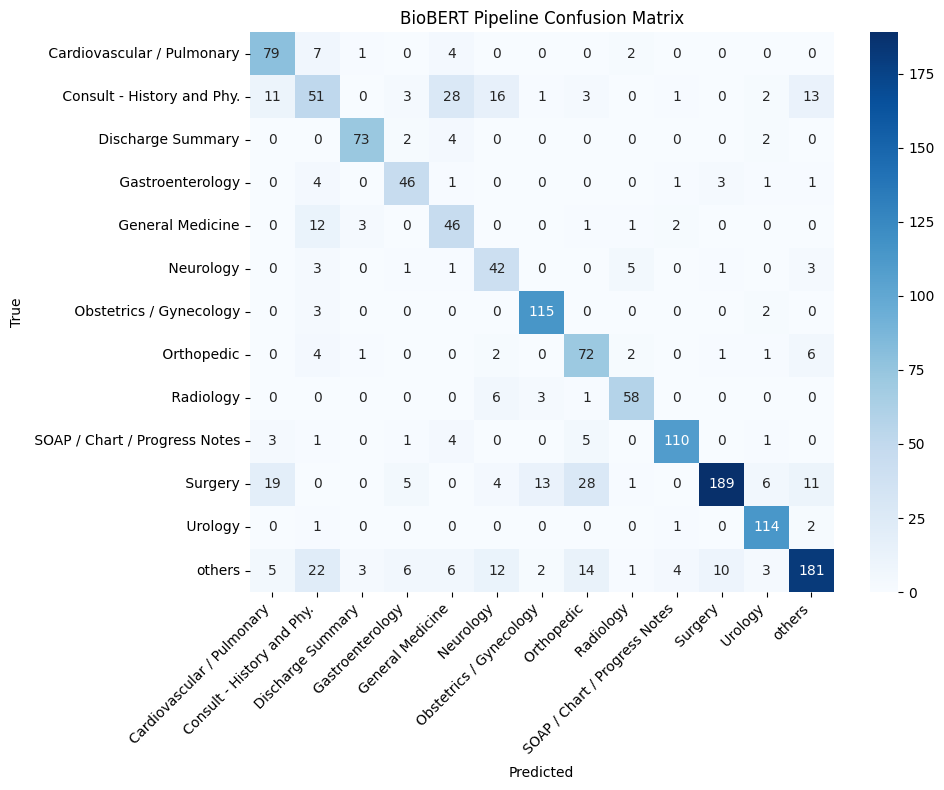

In [56]:
# Load the fine-tuned model into a pipeline for inference
classifier = pipeline(
    "text-classification",
    model="biobert_medical_specialty_classifier",
    tokenizer="biobert_medical_specialty_classifier",
    device=0 if torch.cuda.is_available() else -1
)

# Perform inference on test set
predictions = []
for text in tqdm(X_test, desc="Predicting"):
    result = classifier(text, truncation=True, max_length=512)
    predicted_label = result[0]['label']
    # Extract index from LABEL_<index> format
    try:
        predicted_id = int(predicted_label.replace('LABEL_', ''))
        if predicted_id >= num_classes:
            raise ValueError(f"Predicted ID {predicted_id} exceeds num_classes {num_classes}")
    except ValueError as e:
        print(f"Error processing label {predicted_label}: {e}")
        predicted_id = 0  # Fallback to a default class (e.g., 'others')
    predictions.append(predicted_id)

# Evaluate
accuracy = accuracy_score(y_test, predictions)
f1_macro = f1_score(y_test, predictions, average='macro')
f1_micro = f1_score(y_test, predictions, average='micro')

print("\nBioBERT Pipeline Results:")
print(f"Accuracy: {accuracy:.4f}, Macro F1: {f1_macro:.4f}, Micro F1: {f1_micro:.4f}")
print(classification_report(y_test, predictions, target_names=label_encoder.classes_))

# Plot confusion matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('BioBERT Pipeline Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()